In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns

from matplotlib import colors


from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

In [2]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary
                    
    

In [3]:
protein = '1fme'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits=25
lag = 41
hp_ix = 143

study = 'k3_ev-gap_vamp_eq'
Path(f"figures/{study}").mkdir(exist_ok=True, parents=True)

hps = pd.read_hdf(study+'.h5')

top_path = f'../../data/1fme/protein.pdb'
traj_paths = list(Path('../../data/1fme').rglob(f'*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths



hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 10
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000


# source_ts = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='timescales'))
# source_vs = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='vamps'))

In [4]:
print(hps.loc[hp_ix, :].to_dict())

ftrajs_all = featurizer(hps.loc[hp_ix, :].to_dict(), traj_paths, top_path)
# Bootstrap results
ts_samples = []
vs_samples = []
for i in range(n_bootstraps):
#     if n_bootstraps>1: 
#         print(i, end=', ')
#     ftrajs, ix = bootstrap(ftrajs_all, rng)
#     traj_paths_bs = [traj_paths[i] for i in ix]
    
#     else:
    ftrajs = ftrajs_all
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path(f'dtrajs/hp_{hp_ix}/bs_{i}')
    else:
        out_dir = Path(f'dtrajs/hp_{hp_ix}/dtrajs')
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])

{'hp_ix': 143, 'values_0': 2.6479880633727078, 'values_1': 1.3385921894115715, 'datetime_start': Timestamp('2022-09-16 16:39:40.379636'), 'datetime_complete': Timestamp('2022-09-16 16:44:32.705408'), 'duration': Timedelta('0 days 00:04:52.325772'), 'distances__centre': nan, 'feature__value': 'distances', 'cluster__k': 161, 'distances__scheme': 'ca', 'distances__steepness': nan, 'tica__dim': 1, 'tica__lag': 92, 'distances__transform': 'linear', 'state': 'COMPLETE', 'tica__stride': 1, 'cluster__stride': 10, 'dihedrals__which': 'all', 'cluster__max_iter': 1000}


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

## Timescales

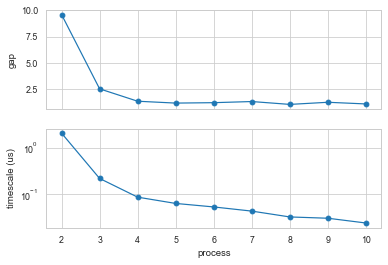

In [5]:
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
n_ts = 10
ts = msm.timescales(n_ts)

with sns.plotting_context('paper'):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, sharex=True)

    axes[0].plot(np.arange(n_ts-1)+2, ts[:-1]/ts[1:], marker='o')
    axes[0].set_ylabel('gap')
    axes[1].plot(np.arange(n_ts-1)+2, ts[:-1]/1000, marker='o')
    axes[1].set_yscale('log')
    axes[1].set_ylabel('timescale (us)')
    axes[1].set_xlabel('process')

    plt.savefig(f'figures/{study}/timescales_hp_ix-{hp_ix}.png', bbox_inches='tight')

In [6]:
ts

array([2072.48853087,  215.61701994,   84.69806369,   61.86860708,
         51.93412029,   42.18964284,   31.50787319,   29.54155344,
         23.2781888 ,   20.95733597])

## Eigenvectors

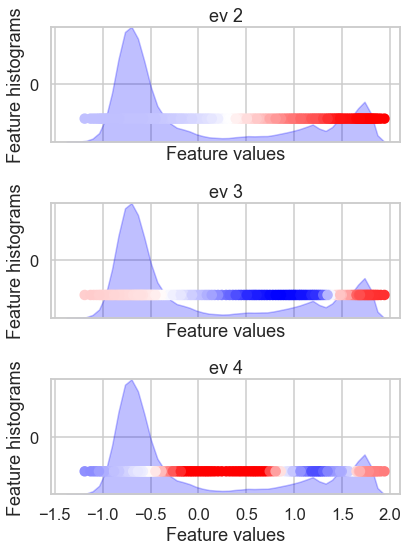

In [7]:
Y = np.concatenate(ttrajs)

vmin = np.min(msm.eigenvectors_right()[:, :3]) 
vmax = np.max(msm.eigenvectors_right()[:, :3])

divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)


with sns.plotting_context('talk'):
    fig, axes = plt.subplots(3, sharex=True, sharey=True, figsize=(6, 8))

    for i_ev, ax in enumerate(axes): 
        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], ax=ax, cmap='viridis', alpha=0.5)
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    

        ax.set_title(f'ev {i_ev+2}')
        ax.scatter(x=x, y=y, 
                  c=msm.eigenvectors_right()[:, i_ev+1], cmap='bwr',norm=divnorm)

    plt.tight_layout()
    plt.savefig(f'figures/{study}/evs_hp_ix-{hp_ix}.png', bbox_inches='tight')

## Distributions

Only keep core sets

In [8]:
core_membership_cutoff = 0.9
n_sets = 2
_ = msm.pcca(n_sets)

In [9]:
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]

In [10]:
max_dists = dists.copy()

mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

max_dists[mask] = 1
max_dists[~mask] = 0

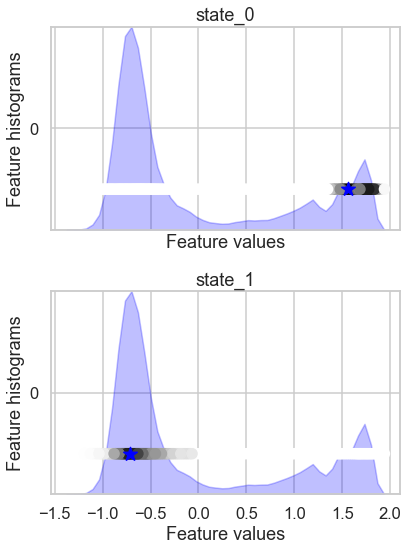

In [11]:

with sns.plotting_context('talk'):
    fig, axes = plt.subplots(n_sets, sharex=True, sharey=True, figsize=(6, 8))


    sns.set_style('white')
    for i_set, ax in enumerate(axes): 
        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], ax=ax, cmap='viridis', alpha=0.5)
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    


        ax.scatter(x=x, y=y, 
                  c=dists[i_set], cmap='Greys', s=100, vmin=dists[i_set].min(), vmax=dists[i_set].max())
        
        ax.scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*', s=200 )
        
        ax.set_title(f'state_{i_set}')
    plt.tight_layout()
    plt.savefig(f'figures/{study}/core_membership_hp_ix-{hp_ix}.png', bbox_inches='tight')


In [12]:
is_single_core = False
if is_single_core: 
    samples = msm.sample_by_distributions(max_dists, 100)
else: 
    samples = msm.sample_by_distributions(dists, 100)
    
ref = md.load('1fme.pdb')

state_out_dir = out_dir.joinpath('../').resolve().joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

states = []

for sample_ix in range(len(samples)):

    outfile = str(state_out_dir.joinpath(f'state_{sample_ix}_is_single_core-{is_single_core}.pdb'))
    
    traj = pm.coordinates.save_traj(traj_paths, samples[sample_ix], 
                                 outfile=None, top=top_path)
    traj.superpose(reference=ref)
    states.append(traj)
    traj.save_pdb(str(outfile))
    
    
rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd*10 for i, rmsd in enumerate(rmsds)}).melt()

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Obtaining file info:   0%|                                                                                    …

Obtaining file info:   0%|                                                                                    …

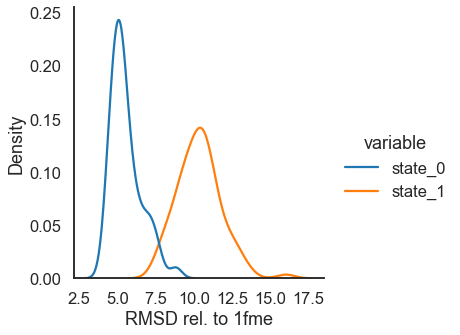

In [13]:
with sns.plotting_context('talk'):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    plt.savefig(f"metastable_states_rmsd_{hp_ix}.png")
    plt.xlabel(f'RMSD rel. to {protein}')
    
    plt.savefig(f'figures/{study}/rmsd_to_xtal_{hp_ix}_single_core-{is_single_core}.png', bbox_inches='tight')